In [ ]:
import torchvision
from torchview import draw_graph
import numpy as np
import pandas as pd
import os
from google.colab import drive
from collections import defaultdict
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gensim.models import KeyedVectors
from itertools import islice
from torch.utils.data import Dataset, DataLoader


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
glove_path = '/content/drive/MyDrive/word_embeddings/glove/glove.6B.300d.txt'
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings(glove_path)

Mounted at /content/drive


In [ ]:
def normalize_embeddings(embeddings):
    norm_embeddings = {}
    for word, vec in embeddings.items():
        norm_embeddings[word] = vec / np.linalg.norm(vec)
    return norm_embeddings

normalized_glove_embeddings = normalize_embeddings(glove_embeddings)

In [ ]:
occupation_words = []
with open('words.txt','r') as file:
  occupation_words = [line.rstrip().replace(' ','-').lower() for line in file]
def check_oov_words(word_list, embeddings):
    oov_words = []
    for word in word_list:
        if word not in embeddings:
            oov_words.append(word)
    return oov_words


oov_occupation = check_oov_words(occupation_words, normalized_glove_embeddings)
occupation_words =set(occupation_words)
oov_occupation =  set(oov_occupation)
occupation_words = occupation_words - oov_occupation

In [ ]:
from sklearn.decomposition import PCA
def pca(matrix):
  n_components = 10
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(matrix)
  principal_component_vector = pca.components_[0]
  #principal_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_components)])
  print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
  #print("Principal Components:\n", principal_df)

  return principal_component_vector

In [ ]:
 def get_gender_axis(normalized_glove_embeddings):fh
  gender_pairs = [('he', 'she'),('his','her'), ('man', 'woman'),('john','mary'),('boy', 'girl'),('himself','herself'),('son','daughter'),('guy','gal'), ('father', 'mother'), ('male','female') ]
  matrix =[]
  for a,b in gender_pairs:
    matrix.append(normalized_glove_embeddings[b] - normalized_glove_embeddings[a])
  matrix = np.array(matrix)
  df = pca(matrix)
  return df

gender_axis = get_gender_axis(normalized_glove_embeddings)

Explained variance ratio of each component: [4.0312684e-01 2.1468970e-01 1.4305896e-01 7.0180491e-02 6.0047414e-02
 4.5551356e-02 3.2000728e-02 1.9898888e-02 1.1445663e-02 5.9663950e-15]


In [ ]:
def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    return 1 - cosine(vec1, vec2)

In [ ]:
def compute_gender_bias(embeddings, occupation_words, gender_axis):
    bias_scores = {}
    for word in occupation_words:
            similarity = cosine_similarity(embeddings[word], gender_axis)
            bias_scores[word] = similarity
    return bias_scores

scores = compute_gender_bias(normalized_glove_embeddings,occupation_words,gender_axis)

In [ ]:
def calculate_direct_bias(scores):
  final_score =0
  for key in scores.keys():
    final_score+=abs(scores[key])
  final_score/= len(scores)
  return final_score

direct_bias_initial = calculate_direct_bias(scores)
print(f'Direct Bias - Initial : {direct_bias_initial}')

Direct Bias - Initial : 0.09191059272812407


In [ ]:
gender_subspace = gender_axis
def remove_gender_bias(embeddings, gender_subspace):
    debiased_embeddings = {}
    for word, vector in embeddings.items():
        projection = np.dot(vector, gender_subspace) * gender_subspace
        debiased_vector = vector - projection
        debiased_embeddings[word] = debiased_vector
    return debiased_embeddings

embeddings = {word:normalized_glove_embeddings[word] for word in occupation_words}
debiased_embeddings = remove_gender_bias(embeddings, gender_subspace)


debiased_gender_bias_scores = compute_gender_bias(debiased_embeddings,occupation_words, gender_subspace)
direct_bias_final = calculate_direct_bias(debiased_gender_bias_scores)
print(f'Direct Bias - Hard Debiasing : {direct_bias_final}')



Direct Bias - Hard Debiasing : 1.257388032880177e-08


In [ ]:
glove_model = dict(islice(normalized_glove_embeddings.items(), 10000))

def get_embedding(word):
    if word in glove_model:
        return glove_model[word]
    else:
        return np.zeros(glove_model.vector_size)

class FixedEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=300):
        super(FixedEmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, embedding_dim)

    def forward(self, word_embeddings):
        x = word_embeddings
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x) + word_embeddings
        return x

In [ ]:
class GloveDataset(Dataset):
    def __init__(self, glove_model):
        self.glove_model = glove_model
        self.words = list(glove_model.keys())

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word = self.words[idx]
        embedding = torch.tensor(self.glove_model[word], dtype=torch.float32)
        return embedding

In [ ]:
def train_embedding_autoencoder(model, glove_model, batch_size=32, epochs=100, lr=0.001):
    dataset = GloveDataset(glove_model)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in dataloader:
            output = model(batch)
            loss = criterion(output, batch)
            epoch_loss += loss.item() * batch.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataset)}")

In [ ]:
model = FixedEmbeddingModel(embedding_dim=300)
train_embedding_autoencoder(model, glove_model, batch_size=32, epochs=20, lr=0.0001)

Epoch 1/20, Loss: 0.00010669661318534054
Epoch 2/20, Loss: 7.257941309944727e-06
Epoch 3/20, Loss: 3.820051733782748e-06
Epoch 4/20, Loss: 2.319976459875761e-06
Epoch 5/20, Loss: 1.4189133267791476e-06
Epoch 6/20, Loss: 8.391429728362709e-07
Epoch 7/20, Loss: 4.697764663887938e-07
Epoch 8/20, Loss: 2.3884598138010914e-07
Epoch 9/20, Loss: 1.246315491812311e-07
Epoch 10/20, Loss: 6.866413713169094e-08
Epoch 11/20, Loss: 4.1182460995514705e-08
Epoch 12/20, Loss: 2.640864771734641e-08
Epoch 13/20, Loss: 1.6635546506904576e-08
Epoch 14/20, Loss: 1.1698408385996118e-08
Epoch 15/20, Loss: 7.957292577742691e-09
Epoch 16/20, Loss: 5.453998863913512e-09
Epoch 17/20, Loss: 3.973250188593624e-09
Epoch 18/20, Loss: 3.3724094741671708e-09
Epoch 19/20, Loss: 2.5331781985826752e-09
Epoch 20/20, Loss: 1.9148527464096787e-09


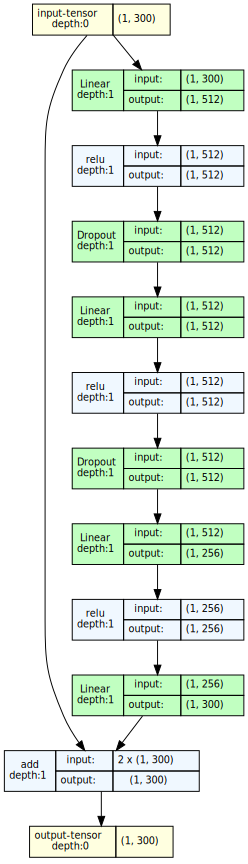

In [ ]:
model_graph = draw_graph(model, input_size=(1,300), expand_nested=True)
model_graph.visual_graph

In [ ]:
def evaluate_embedding_autoencoder(model, glove_model, batch_size=32):
    model.eval()
    dataset = GloveDataset(glove_model)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    criterion = nn.MSELoss()

    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            output = model(batch)
            loss = criterion(output, batch)
            total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Evaluation Loss (Reconstruction Error): {avg_loss}")
    return avg_loss

In [ ]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha=1.0):
        ctx.alpha = alpha
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

def apply_grl(x, alpha=1.0):
    return GradientReversalLayer.apply(x, alpha)

class AdversaryModel(nn.Module):
    def __init__(self, input_dim):
        super(AdversaryModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.fc2 = nn.Linear(128, 256)
        # self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return self.sigmoid(x)



def train_adversarial_model(glove_model,adversary_model, embedding_model, num_epochs=100, lr=0.001, alpha=1.0):

    optimizer = optim.Adam(list(embedding_model.parameters()) + list(adversary_model.parameters()), lr=lr)
    criterion = nn.BCELoss()
    words = scores.keys()
    labels = torch.tensor([scores[x] for x in scores.keys() ], dtype=torch.float32)
    labels = torch.sigmoid(labels)
    # min_score =labels.min()
    # max_score = labels.max()
    # labels = (labels - min_score) / (max_score - min_score)

    for epoch in range(num_epochs):
        embedding_model.train()
        adversary_model.train()
        optimizer.zero_grad()

        embeddings = torch.stack([torch.tensor(glove_model[word], dtype=torch.float32) for word in words])
        transformed_embeddings = embedding_model(embeddings)

        reversed_embeddings = apply_grl(transformed_embeddings, alpha)
        gender_predictions = adversary_model(reversed_embeddings).squeeze()

        adversary_loss = criterion(gender_predictions, labels)
        adversary_loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Adversarial Loss: {adversary_loss.item():.4f}")




In [ ]:
import copy
model_use = copy.deepcopy(model)

In [ ]:
adversary_model = AdversaryModel(input_dim=300)
train_adversarial_model(normalized_glove_embeddings,adversary_model, model_use, num_epochs=110, lr=0.0009, alpha=3.5)

Epoch [10/110], Adversarial Loss: 0.6919
Epoch [20/110], Adversarial Loss: 0.6921
Epoch [30/110], Adversarial Loss: 0.7045
Epoch [40/110], Adversarial Loss: 0.7164
Epoch [50/110], Adversarial Loss: 0.6947
Epoch [60/110], Adversarial Loss: 0.6954
Epoch [70/110], Adversarial Loss: 0.7041
Epoch [80/110], Adversarial Loss: 0.7003
Epoch [90/110], Adversarial Loss: 0.7101
Epoch [100/110], Adversarial Loss: 0.8247
Epoch [110/110], Adversarial Loss: 1.1907


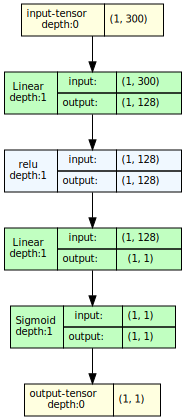

In [ ]:
model_graph = draw_graph(adversary_model, input_size=(1,300), expand_nested=True)
model_graph.visual_graph

In [ ]:
def get_new_embeddings(word_embedding_dict, embedding_model):

    updated_embeddings = {}
    embedding_model.eval()

    with torch.no_grad():
        for word, embedding in word_embedding_dict.items():
           embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)
           updated_embedding = embedding_model(embedding_tensor)
           updated_embeddings[word] = updated_embedding.squeeze(0).numpy()  # Convert tensor to numpy array and remove batch dimension

    return updated_embeddings


In [ ]:
oc_embeddings = {word:normalized_glove_embeddings[word] for word in occupation_words}

In [ ]:
updated_embeddings = get_new_embeddings(oc_embeddings, model_use)
debiased_scores = compute_gender_bias(updated_embeddings,occupation_words, gender_subspace)
direct_bias_adv = calculate_direct_bias(debiased_scores)
print(f'Direct Bias - Adv : {direct_bias_adv}')

Direct Bias - Adv : 0.0052856284367159365


In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model_use, file)

In [ ]:
with open('embeddings.pkl', 'wb') as file:
    pickle.dump(updated_embeddings,file)

In [ ]:
def calculate_weat(embeddings, target_set, attribute_sets):

    attribute_A, attribute_B = attribute_sets

    def association(target_vector, attribute_set_vectors):
        return np.mean([np.dot(target_vector, attr_vec) for attr_vec in attribute_set_vectors])

    weat_score = 0
    attribute_A_vectors = [embeddings.get(word, np.zeros(300)) for word in attribute_A]
    attribute_B_vectors = [embeddings.get(word, np.zeros(300)) for word in attribute_B]

    for word in target_set:
        word_vec = embeddings.get(word, np.zeros(300))
        weat_score += association(word_vec, attribute_A_vectors) - association(word_vec, attribute_B_vectors)

    return weat_score

occupation_words = [word for word in updated_embeddings]
gendered_words_male = ["he", "him", "his", "man", "male"]
gendered_words_female = ["she", "her", "hers", "woman", "female"]

target_set = occupation_words
attribute_sets = [gendered_words_male, gendered_words_female]


weat_score_original = calculate_weat(normalized_glove_embeddings, target_set, attribute_sets)
print("WEAT Score Original:", weat_score_original)
weat_score_adversarial = calculate_weat(updated_embeddings, target_set, attribute_sets)
print("WEAT Score Adversarial:", weat_score_adversarial)
weat_score_debiased = calculate_weat(debiased_embeddings, target_set, attribute_sets)
print("WEAT Score Hard Debiasing:", weat_score_debiased)

WEAT Score Original: -1.49872194416821
WEAT Score Adversarial: 0.0
WEAT Score Hard Debiasing: 0.0


In [ ]:
print(f'Direct Bias - Initial : {direct_bias_initial}')
print(f'Direct Bias - Adversarial : {direct_bias_adv}')
print(f'Direct Bias - Hard Debiasing : {direct_bias_final}')

Direct Bias - Initial : 0.09191059272812407
Direct Bias - Adversarial : 0.0052856284367159365
Direct Bias - Hard Debiasing : 1.257388032880177e-08
